In [1]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

In [2]:
# Eq. 25, https://en.wikipedia.org/wiki/Kepler_orbit#Properties_of_trajectory_equation
# Note eq. 24 implies a unique E for all t and 0 < e < 1.
t2E = lambda e, t : fsolve(lambda E : E - e*np.sin(E) - t, t/(1 - e))

In [3]:
circlexy = lambda r, θ : (r*np.cos(θ), r*np.sin(θ))

In [4]:
e = .1                   # eccentricity
G = 6.67430e-11          # gravitational constant, m³/(kg s²) https://en.wikipedia.org/wiki/Gravitational_constant
m = [1e3, 5.9722e24]     # masses of satellite, earth, kg https://en.wikipedia.org/wiki/Earth_mass
N = 250                   # nu. plot points
R = 6371.0088e3          # mean earth radius, m https://en.wikipedia.org/wiki/Earth_radius
α = G*sum(m)             # gravitational parameter, eq. 1, m³/s²
a = (R + 4e5)/(1 - e)    # eq. 35, R + minimum altitude solved for semi-major axis, m
p = a*(1 - e*e)          # eqs. 13--14, r(θ=π/2), θ being the true anomaly
b = a*(1 - e*e)**.5      # eq. 15, semi-minor axis
H = (α*p)**.5            # eq. 26, specific relative angular-momentum magnitude, m²/s
P = 2*np.pi*a**1.5/α**.5 # eq. 43, orbital period for an elliptic orbit, s
t = np.linspace(0,
               .99*P, N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list

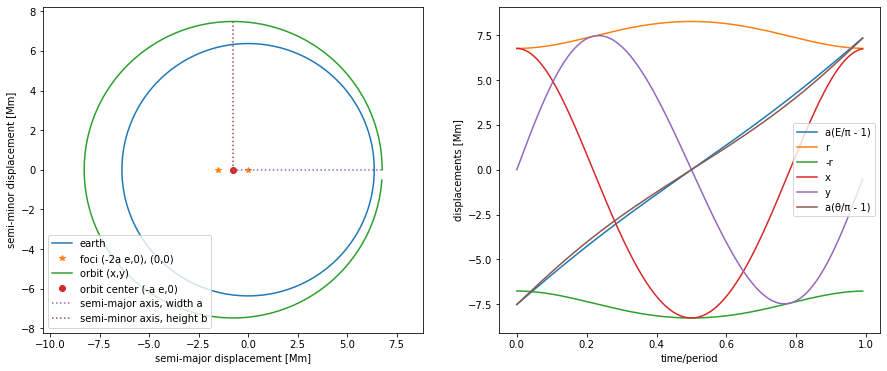

In [5]:
#plt.plot(t/24/3600, E)
X = circlexy(R/1e6,        # curve of earth section by orbital plane
             np.linspace(0, 2*np.pi, N))
f = plt.figure(figsize=(15,6))
ax = [f.add_subplot(1,2,1), f.add_subplot(1,2,2)]
ax[0].plot(X[0], X[1], label='earth')
ax[0].plot([0, -2*a*e/1e6], [0, 0], '*', label='foci (-2a e,0), (0,0)')
ax[0].plot(x/1e6, y/1e6, label='orbit (x,y)')
ax[0].plot(-a*e/1e6, 0, 'o', label='orbit center (-a e,0)')
ax[0].plot(np.array([-e, 1 - e])*a/1e6, np.array([0, 0]), ':', label='semi-major axis, width a')
ax[0].plot(-np.array([1, 1])*a*e/1e6, np.array([0, 1])*b/1e6, ':', label='semi-minor axis, height b')
ax[0].set_xlabel('semi-major displacement [Mm]')
ax[0].set_ylabel('semi-minor displacement [Mm]')
ax[0].axis('equal')
ax[0].legend(loc='lower left')
ax[1].plot(t/P, a*(E/np.pi - 1)/1e6, label='a(E/π - 1)')
ax[1].plot(t/P, a*(1 - e*np.cos(E))/1e6, label='r')
ax[1].plot(t/P, a*(e*np.cos(E) - 1)/1e6, label='-r')
ax[1].plot(t/P, x/1e6, label='x')
ax[1].plot(t/P, y/1e6, label='y')
ax[1].plot(t/P, a*(np.arctan2(y, x)/np.pi - 1 + 2*np.heaviside(t/P - .5, .5)
                  )/1e6, label='a(θ/π - 1)')
ax[1].set_xlabel('time/period')
ax[1].set_ylabel('displacements [Mm]')
ax[1].legend()

In [7]:
def xy2q(t, x, y, i, ω, Ω) : # map orbit to 3D coordinates (x,y) to (q[0],q[1],q[2])
    W = [np.cos(Ω),          # longitude of the ascending node converted to its cosine and sine
         np.sin(Ω)]
    ν = np.sin(i)             # sine of inclination angle
    l = ω + 2*np.pi*t/24/3600 # time (s) converted to orbital plane normal-vector azimuth (radian)
        # little omega is the arugment of pergigree
    ν = np.array([np.cos(l)*ν,# ν converted to unit normal vector of orbital plane
                  np.sin(l)*ν, np.array([np.cos(i)]*len(l))]).transpose()
    λ = np.cross([0, 0, 1], ν)# vector orthogonal to ν and to reference North Pole
    λ = np.diag(np.sum(λ*λ,   # normalize λ
                       axis=1)**-.5)@λ
    μ = np.cross(ν, λ)        # unit vector orthogonal to λ and to ν
    q = (np.diag(x)@λ + np.diag(y)@μ)@np.array([[W[0], -W[1], 0],
                                                [W[1],  W[0], 0],
                                                [   0,     0,  1]])
    return q


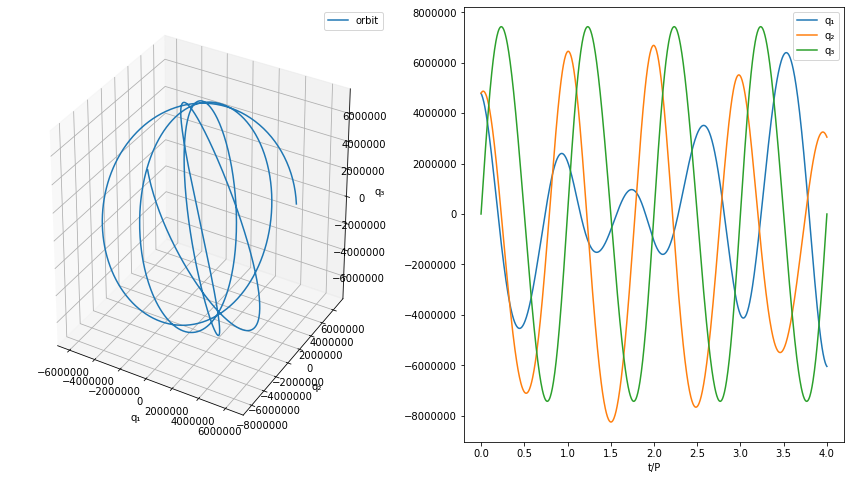

In [8]:
inclination = 1.449   # np.sin takes radians   83° × π/180 = 1.449rad
t = np.linspace(0,
               4*P, 4*N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list
q = xy2q(t, x, y, inclination, 0, np.pi/4)
f = plt.figure(figsize=(15,8))
ax = [f.add_subplot(1,2,1,projection='3d'), f.add_subplot(1,2,2)]
ax[0].plot(q[:,0], q[:,1], q[:,2], label='orbit')
ax[0].set_xlabel('q₁')
#ax[0].set_xlim3d(-8, 8)
ax[0].set_ylabel('q₂')
#ax[0].set_ylim3d(-8, 8)
ax[0].set_zlabel('q₃')
#ax[0].set_zlim3d(-8, 8)
ax[0].legend()
ax[1].plot(t/P, q[:,0], label='q₁')
ax[1].plot(t/P, q[:,1], label='q₂')
ax[1].plot(t/P, q[:,2], label='q₃')
ax[1].set_xlabel('t/P')
ax[1].legend();

In [9]:
circlexyz = lambda r, θ, ω : (r*np.sin(θ)*np.cos(ω), r*np.sin(θ)*np.sin(ω),r*np.cos(θ) )

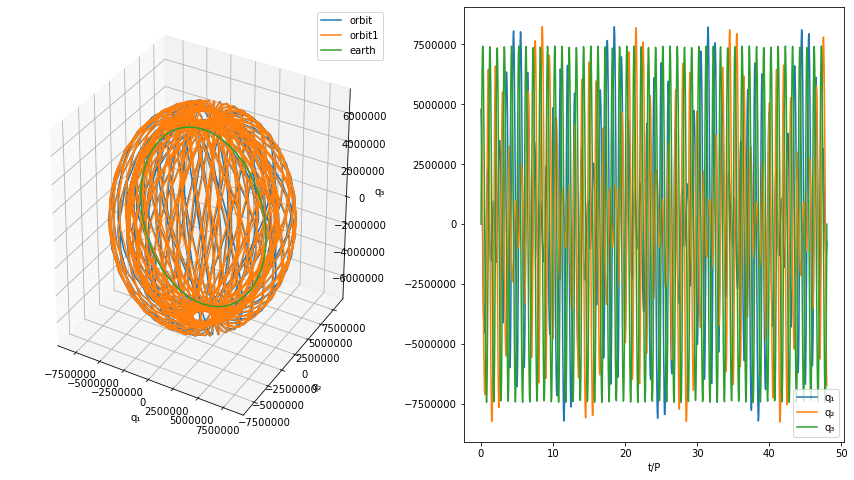

In [87]:
X = circlexyz( R, np.linspace(0, 2*np.pi, N), 0 )

PP = 48 # Number of orbits we wish to simulate
inclination =  1.449   # np.sin takes radians   83° × π/180 = 1.449rad
t = np.linspace(0, PP*P, 4*N) # time list, s
E = t2E(e, H*t/a/b)      # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)    # eq. 20, x-coordinate list
y = b*np.sin(E)          # eq. 21, y-coordinate list
q = xy2q(t, x, y, inclination, 0, np.pi/4)
q1 = xy2q(t, x, y, inclination, np.pi/2, np.pi/4)
f = plt.figure(figsize=(15,8))
ax = [f.add_subplot(1,2,1,projection='3d'), f.add_subplot(1,2,2)]
ax[0].plot(q[:,0], q[:,1], q[:,2], label='orbit')
ax[0].plot(q1[:,0], q1[:,1], q1[:,2], label='orbit1')
ax[0].plot(X[0], X[1], X[2], label='earth')
ax[0].set_xlabel('q₁')
#ax[0].set_xlim3d(-8, 8)
ax[0].set_ylabel('q₂')
#ax[0].set_ylim3d(-8, 8)
ax[0].set_zlabel('q₃')
#ax[0].set_zlim3d(-8, 8)
ax[0].legend()
ax[1].plot(t/P, q[:,0], label='q₁')
ax[1].plot(t/P, q[:,1], label='q₂')
ax[1].plot(t/P, q[:,2], label='q₃')
ax[1].set_xlabel('t/P')
ax[1].legend();

$\psi = arctan(\frac{q_1}{q_2})$

$\phi = arcsin(\frac{q_3}{|q|})$

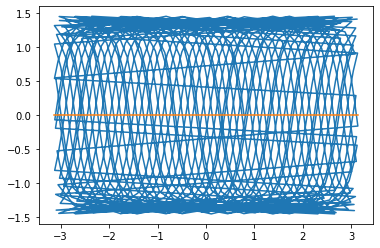

In [88]:
psi = np.arctan2(q[:,0], q[:,1]) 

qq = np.zeros(np.size(q[:,2]))
for i in range(0,np.size(q[:,1])):
    qq[i] = q[i,2] / np.sqrt( q[i,0]**2 + q[i,1]**2 + q[i,2]**2 )

phi = np.arcsin( qq )
plt.plot(psi, phi)
plt.plot([-np.pi,np.pi],[0,0])

In [89]:
# Setting up parameters needed to find area of
#               swath that crosses the equator
x1 = []
y1 = []
x2 = []
y2 = []
slope = []
tan_slope = []

In [90]:
# Finding when the satellite crosses the equator
#   and accumulating the points to form the line
for i in range(0,np.size(phi)-1):
    if( phi[i] > 0 and phi[i+1] < 0 ):
        x1.append( psi[i] )            # x1
        x2.append( psi[i+1] )          # x2
        y1.append( phi[i] )            # y1
        y2.append( phi[i+1] )          # y2
    else:
        if( phi[i] < 0 and phi[i+1] > 0 ):
            x1.append( psi[i] )            # x1
            x2.append( psi[i+1] )          # x2
            y1.append( phi[i] )            # y1
            y2.append( phi[i+1] )          # y2

In [91]:
# Calculating slope of the line crossing the equator.        
for i in range(0,np.size(x1)):
    m1 = y1[i] - y2[i]
    m2 = x1[i] - x2[i]
    m  = ( m1 / m2 )
    slope.append( m )  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


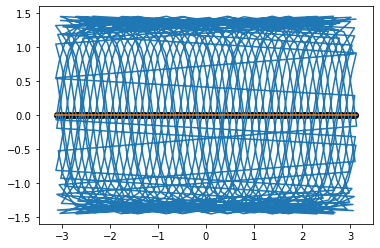

In [117]:
# Calculating things from Aime's email
u1 = []
v1 = []
a1 = []
b1 = []
swath = .0214
s = swath/2

for i in range(0,np.size(x1)):
    u1.append( x2[i] - x1[i] )
    v1.append( y2[i] - y1[i] )        

for i in range(0,np.size(x1)):
    a1.append( x1[i] - (u1[i]/v1[i])*y1[i] )
    b1.append( 0 )        

colors = (0,0,0)
plt.plot(psi, phi)
plt.plot([-np.pi,np.pi],[0,0])
plt.scatter(a1,b1,c=colors)

In [118]:
# Using what Greg thinks should work
theta = []
h = []
pp = []

for i in range(0,np.size(slope)):
    theta.append( np.arctan( slope[i] ) )

for i in range(0,np.size(theta)):
    h.append( s / (np.cos(theta[i])) )

for i in range(0,np.size(theta)):
    pp.append( h[i] / np.tan( theta[i] ) )

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


[-2.5814117817359197, 0.3024511743815049, -3.053712306219155, -0.16990017715997136, 2.75724228910281, -0.6423684036710365, 2.2850377305377134, -1.1147821827409616, 1.812752218773595, -1.5869664749753274, 1.3404301425222866, -2.0589392501037866, 0.8681166905282223, -2.531212549439558, 0.39585743467504153, -3.003661001236834, -0.0763342882097967, 2.8070733496840328, -0.5485973354108816, 2.334792398682633, -1.0209122864525615, 1.8628158666835004, -1.4932336180448742, 1.3906410196870798, -1.9655161032751975, 0.918231435324445, -2.4377173645733423, 0.4457623768896334, -2.9099526377342286, -0.02659488423754281, 2.9009298860939507, -0.49866142669532637, 2.428605683028098, -0.9707166679543233, 1.9563051586062867, -1.4430680195253636, 1.484074446975725, -1.915536245591254, 1.0118698868709355, -2.3879500268028044, 0.5395843787331897, -2.860134321894564, 0.06726230304178457, 2.9510782236349393, -0.40505116285537923, 2.47880492194499, -0.8773104023126136, 2.0063564618652614, -1.3495021308546125, 1

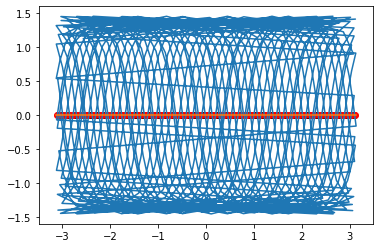

In [119]:
equator_catch_plus = []
equator_catch_minus = []
for i in range(0,np.size(x1)):
    equator_catch_plus.append( a1[i] + pp[i] )
    equator_catch_minus.append( a1[i] - pp[i] )
print(equator_catch_plus,'\n')
print(equator_catch_minus)

colors1 = (0,0,0)
colors2 = (1,0,0)
plt.plot(psi, phi)
plt.plot([-np.pi,np.pi],[0,0])
plt.scatter(equator_catch_plus,b1,c=colors1)
plt.scatter(equator_catch_minus,b1,c=colors2)

In [120]:
# Need to pip install the below line to use interval
#pip install pyinterval

In [121]:
from interval import interval, inf, imath

In [122]:
checking_int = interval([1.0,3.0],[2.0,4.0],[7.0,10.0])
print(checking_int)

interval([1.0, 4.0], [7.0, 10.0])


In [123]:
checking_int = interval([8.0, 20.0]) | interval([1.0,3.0],[2.0,4.0],[7.0,10.0])
print(checking_int)

interval([1.0, 4.0], [7.0, 20.0])


In [124]:
interval_caught1 = []
interval_caught2 = []

for i in range(0,np.size(equator_catch_plus),2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught1.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
#        interval_caught1.append( [ equator_catch_plus[i], equator_catch_minus[i] ] )
    else:
        interval_caught1.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
#        interval_caught1.append( [ equator_catch_minus[i], equator_catch_plus[i] ] )        
    
for i in range(1,np.size(equator_catch_plus),2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught2.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
#        interval_caught2.append( [ equator_catch_plus[i], equator_catch_minus[i] ] )
    else:
        interval_caught2.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
#        interval_caught2.append( [ equator_catch_minus[i], equator_catch_plus[i] ] )
    
print(np.size(interval_caught1,0),interval_caught1,'\n')
print(interval_caught2)

print('\n')
area_passed_over_eq1 = interval_caught1[0]
for i in range(1,np.size(interval_caught1,0)):
    area_passed_over_eq1 = interval( area_passed_over_eq1 ) | interval( interval_caught1[i] )

area_passed_over_eq2 = interval_caught2[0]
for i in range(1,np.size(interval_caught2,0)):
    area_passed_over_eq2 = interval( area_passed_over_eq2 ) | interval( interval_caught2[i] )
    
print(area_passed_over_eq1)
print('\n')
print(area_passed_over_eq2)

48 [[0.5382912517687508, 0.5601808718538734], [0.06598847145061004, 0.08788034737063821], [5.876938490796095, 5.898834942692603], [5.40473724577844, 5.426630384127506], [4.932454752788432, 4.954344872363388], [4.46013342535268, 4.48202279611208], [3.987818473415658, 4.009709344118015], [3.515555426190355, 3.5374500882648348], [3.043363703305113, 3.0652583653799965], [2.5711044474738873, 2.5929953181789114], [2.0987909963932116, 2.120680367137232], [1.6264689159892167, 1.648359035544919], [1.1541834119113374, 1.1760765503145956], [0.6819788368938964, 0.7038752890164508], [0.20974813995444386, 0.23164001585556449], [6.020632919609029, 6.042522539683744], [5.548308716532859, 5.570198336617891], [5.076005936276292, 5.09789781219608], [4.603770648666435, 4.6256671005655186], [4.131569402087414, 4.153462540460729], [3.6592869127580285, 3.681177032322983], [3.186965585925721, 3.2088549566315776], [2.7146506201735865, 2.736541490734414], [2.242387589099597, 2.2642822512771796], [1.770195860666

In [125]:
def coverage_correction_left(interval_correct):
    # Capture what we need
    left_endpoint = interval_correct[0]
    area_covered = interval([0,left_endpoint[1]])
    # Remove the negative portion of the crossing
    for i in range(1,np.size(interval_correct,0)):
        area_covered = interval(area_covered) | interval(interval_correct[i])
    # Capture the crossing on the other part of the interval
    dist_passed = abs(left_endpoint[0])
    right_int = [2*np.pi - dist_passed, 2*np.pi]
    # Insert interval on the end of area_covered
    print(area_covered)
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

def coverage_correction_right(interval_correct):
    # Capture what we need
    right_endpoint = interval_correct[-1]
    area_covered = interval([right_endpoint[0],2*np.pi])
    # Remove the negative portion of the crossing
    for i in range(0,np.size(interval_correct,0)-1):
        area_covered = interval(area_covered) | interval(interval_correct[i])
    # Capture the crossing on the other part of the interval
    dist_passed = abs(right_endpoint[1])
    right_int = [0, dist_passed - 2*np.pi]
    # Insert interval on the end of area_covered
    print(area_covered)
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

In [126]:
# Post processing:
#    We have a case where we go beyond the [0,2pi] range.
area_covered1 = []
area_covered2 = []
tol = -1e-10

# This checks the boolean of how negative the left end-point is
boo = tol in interval(area_passed_over_eq1[0])
if( boo == True ):
    area_covered1_left = coverage_correction_left(area_passed_over_eq1)
    print('\n')
    print(area_covered1_left)
    print('\n')
    print(area_passed_over_eq1)

print('\n')
boo = tol in interval(area_passed_over_eq2[0])
if( boo == True ):
    area_covered2_left = coverage_correction_left(area_passed_over_eq2)    
    print('\n')
    print(area_covered2_left)
    print('\n')
    print(area_passed_over_eq2)

In [127]:
# Now to fix the right endpoint if we go past 2*pi

# Post processing:
#    We have a case where we go beyond the [0,2pi] range.
tol = 1e-10

# This checks the boolean of how negative the left end-point is
boo = 2*np.pi + tol in interval(area_passed_over_eq1[-1])

if( boo == True ):
    area_covered1_right = coverage_correction_right(area_passed_over_eq1)
    print('\n')
    print(area_covered1_right)
    print('\n')
    print(area_passed_over_eq1)

print('\n')
boo = 2*np.pi + tol in interval(area_passed_over_eq2[-1])
if( boo == True ):
    area_covered2_right = coverage_correction_right(area_passed_over_eq2)    
    print('\n')
    print(area_covered2_right)
    print('\n')
    print(area_passed_over_eq2)

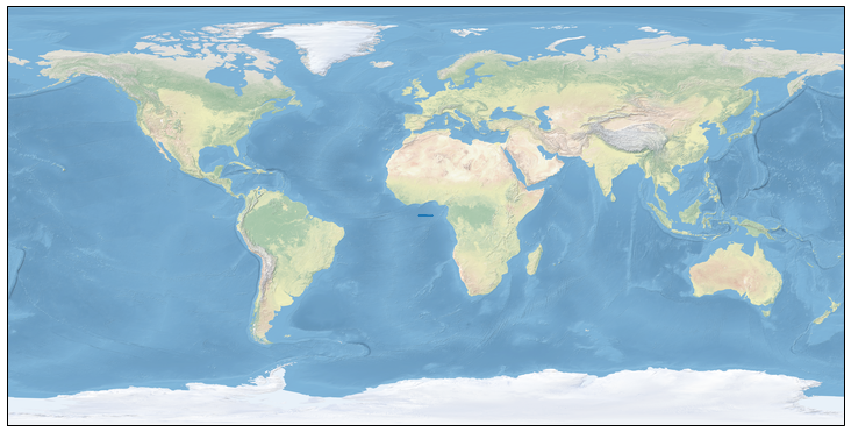

In [21]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
plt.plot(psi, phi)